In [ ]:
pip install fuzzywuzzy

In [ ]:
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
import numpy as np

class Recommender:
  def __init__(self, metric, algorithm, k, data, decode_id_song):
    self.metric = metric
    self.algorithm = algorithm
    self.k = k
    self.data = data
    self.decode_id_song = decode_id_song
    self.data = data
    self.model = self._recommender().fit(data)
    
  def make_recommendation(self, new_song, n_recommendations):
    recommended = self._recommend(new_song=new_song, n_recommendations=n_recommendations)
    print("... Done")
    return recommended 
    
  def _recommender(self):
    return NearestNeighbors(metric=self.metric, algorithm=self.algorithm, n_neighbors=self.k, n_jobs=-1)
    
  def _recommend(self, new_song, n_recommendations):
    # Get the id of the recommended songs
    recommendations = []
    recommendation_ids = self._get_recommendations(new_song=new_song, n_recommendations=n_recommendations)
    # return the name of the song using a mapping dictionary
    recommendations_map = self._map_indeces_to_song_title(recommendation_ids)
    # Translate this recommendations into the ranking of song titles recommended
    for i, (idx, dist) in enumerate(recommendation_ids):
      recommendations.append(recommendations_map[idx])
    return recommendations
                 
  def _get_recommendations(self, new_song, n_recommendations):
    # Get the id of the song according to the text
    recom_song_id = self._fuzzy_matching(song=new_song)
    # Start the recommendation process
    print(f"Starting the recommendation process for {new_song} ...")
    # Return the n neighbors for the song id
    distances, indices = self.model.kneighbors(self.data[recom_song_id], n_neighbors=n_recommendations+1)
    return sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    
  def _map_indeces_to_song_title(self, recommendation_ids):
    # get reverse mapper
    return {song_id: song_title for song_title, song_id in self.decode_id_song.items()}
  
  def _fuzzy_matching(self, song):
    match_tuple = []
    # get match
    for title, idx in self.decode_id_song.items():
      ratio = fuzz.ratio(title.lower(), song.lower())
      if ratio >= 60:
        match_tuple.append((title, idx, ratio))
        # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
      print(f"The recommendation system could not find a match for {song}")
      return
    return match_tuple[0][1]

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
!pip install recommenders

In [ ]:
from recommeders.knn_recommender import Recommender

In [ ]:
song_info = pd.read_csv('10000.txt',sep='\t',header=None)
song_info.columns = ['user_id', 'song_id', 'listen_count']

In [ ]:
song_actual =  pd.read_csv('song_data.csv')
song_actual.drop_duplicates(['song_id'], inplace=True)

In [ ]:
songs = pd.merge(song_info, song_actual, on="song_id", how="left")
songs.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1.0,The Cove,Thicker Than Water,Jack Johnson,0.0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2.0,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976.0
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1.0,Stronger,Graduation,Kanye West,2007.0
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1.0,Constellations,In Between Dreams,Jack Johnson,2005.0
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1.0,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999.0


In [ ]:
songs.to_csv('songs.csv', index=False)

In [ ]:
df_songs = pd.read_csv('songs.csv')
df_songs.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1.0,The Cove,Thicker Than Water,Jack Johnson,0.0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2.0,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976.0
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1.0,Stronger,Graduation,Kanye West,2007.0
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1.0,Constellations,In Between Dreams,Jack Johnson,2005.0
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1.0,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999.0


In [ ]:
print(f"There are {df_songs.shape[0]} observations in the dataset")

There are 135177 observations in the dataset


In [ ]:
unique_songs = df_songs['title'].unique().shape[0]
print(f"There are {unique_songs} unique songs in the dataset")

There are 9555 unique songs in the dataset


In [ ]:
unique_artists = df_songs['artist_name'].unique().shape[0]
print(f"There are {unique_artists} unique artists in the dataset")

There are 3374 unique artists in the dataset


In [ ]:
unique_users = df_songs['user_id'].unique().shape[0]
print(f"There are {unique_users} unique users in the dataset")

There are 5182 unique users in the dataset


In [ ]:
ten_pop_songs = df_songs.groupby('title')['listen_count'].count().reset_index().sort_values(['listen_count', 'title'], ascending = [0,1])
ten_pop_songs['percentage']  = round(ten_pop_songs['listen_count'].div(ten_pop_songs['listen_count'].sum())*100, 2)

In [ ]:
ten_pop_songs = ten_pop_songs[:10]
ten_pop_songs

,title,listen_count,percentage
6826,Sehr kosmisch,591,0.44
8713,Undo,495,0.37
1959,Dog Days Are Over (Radio Edit),490,0.36
9483,You're The One,443,0.33
6815,Secrets,429,0.32
6488,Revelry,414,0.31
3431,Horn Concerto No. 4 in E flat K495: II. Romanc...,348,0.26
2590,Fireflies,339,0.25
8482,Tive Sim,327,0.24
3316,Hey_ Soul Sister,318,0.24


In [ ]:
labels = ten_pop_songs['title'].tolist()
counts = ten_pop_songs['listen_count'].tolist()

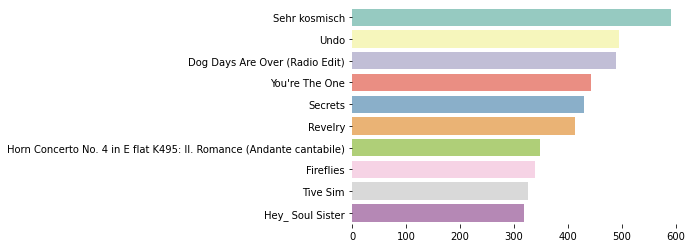

In [ ]:
plt.figure()
sns.barplot(x=counts, y=labels, palette='Set3')
sns.despine(left=True, bottom=True)

In [ ]:
ten_pop_artists  = df_songs.groupby(['artist_name'])['listen_count'].count().reset_index().sort_values(['listen_count', 'artist_name'], ascending = [0,1])

In [ ]:
ten_pop_artists = ten_pop_artists[:10]
ten_pop_artists

,artist_name,listen_count
647,Coldplay,1903
2848,The Black Keys,1518
1105,Florence + The Machine,1312
1649,Kings Of Leon,1273
1368,Jack Johnson,1205
2944,The Killers,1039
2372,Radiohead,967
734,Daft Punk,944
1552,Justin Bieber,922
976,Eminem,849


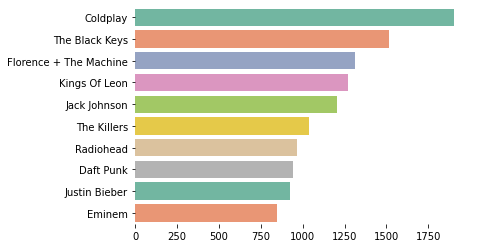

In [ ]:
plt.figure()
labels = ten_pop_artists['artist_name'].tolist()
counts = ten_pop_artists['listen_count'].tolist()
sns.barplot(x=counts, y=labels, palette='Set2')
sns.despine(left=True, bottom=True)

In [ ]:
listen_counts = pd.DataFrame(df_songs.groupby('listen_count').size(), columns=['count'])

In [ ]:
print(f"The maximum time the same user listened to the same songs was: {listen_counts.reset_index(drop=False)['listen_count'].iloc[-1]}")

The maximum time the same user listened to the same songs was: 796.0


In [ ]:
print(f"On average, a user listen to the same song {df_songs['listen_count'].mean()} times")

On average, a user listen to the same song 3.0382686275670236 times


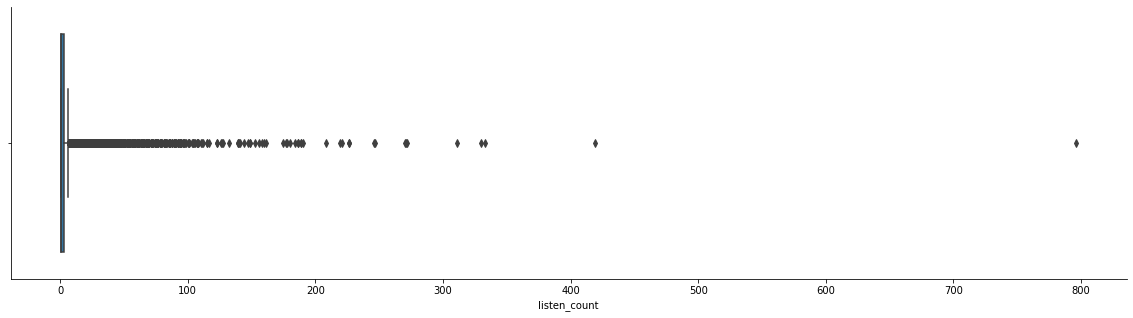

In [ ]:
plt.figure(figsize=(20, 5))
sns.boxplot(x='listen_count', data=df_songs)
sns.despine()

In [ ]:
listen_counts_temp = listen_counts[listen_counts['count'] > 50].reset_index(drop=False)

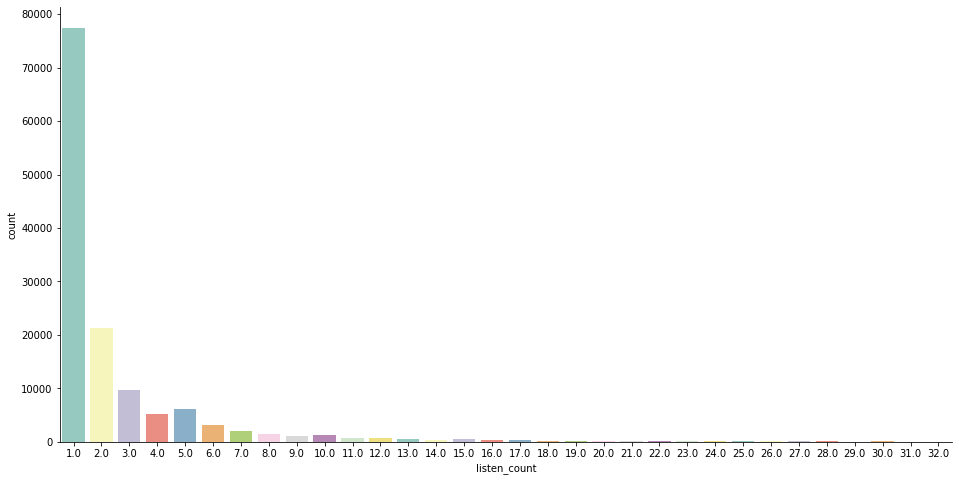

In [ ]:
plt.figure(figsize=(16, 8))
sns.barplot(x='listen_count', y='count', palette='Set3', data=listen_counts_temp)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
song_user = df_songs.groupby('user_id')['song_id'].count()

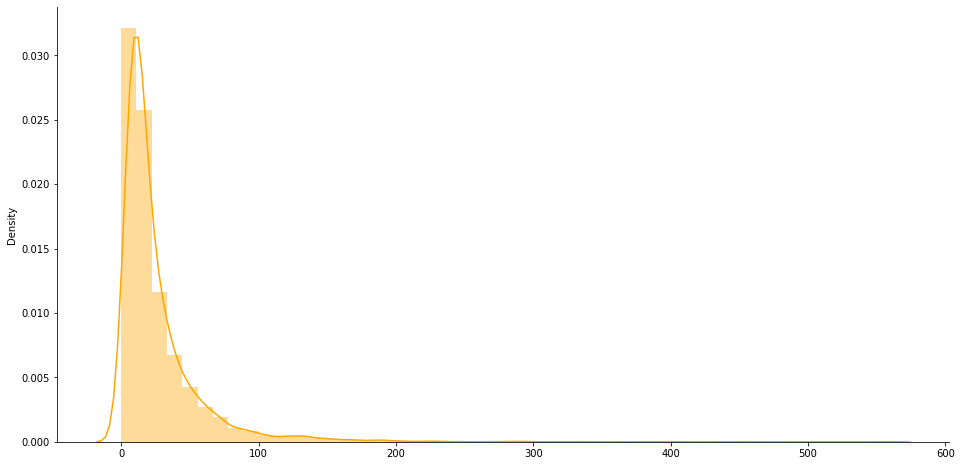

In [ ]:
plt.figure(figsize=(16, 8))
sns.distplot(song_user.values, color='orange')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
print(f"A user listens to an average of {np.mean(song_user)} songs")

A user listens to an average of 26.085681204168274 songs


In [ ]:
print(f"A user listens to an average of {np.median(song_user)} songs, with minimum {np.min(song_user)} and maximum {np.max(song_user)} songs")

A user listens to an average of 16.0 songs, with minimum 0 and maximum 556 songs


In [ ]:
values_matrix = unique_users * unique_songs

In [ ]:
zero_values_matrix = values_matrix - df_songs.shape[0]

In [ ]:
print(f"The matrix of users x songs has {zero_values_matrix} values that are zero")

The matrix of users x songs has 49378833 values that are zero


In [ ]:
song_ten_id = song_user[song_user > 16].index.to_list()

In [ ]:
df_song_id_more_ten = df_songs[df_songs['user_id'].isin(song_ten_id)].reset_index(drop=True)

In [ ]:
df_songs_features = df_song_id_more_ten.pivot(index='song_id', columns='user_id', values='listen_count').fillna(0)
mat_songs_features = csr_matrix(df_songs_features.values)

In [ ]:
df_songs_features.head()

user_id,000ebc858861aca26bac9b49f650ed424cf882fc,002543003041db1d049206b09426d5cdffc0f451,00342a0cdf56a45465f09a39040a5bc25b7d0046,0039bd8483d578997718cdc0bf6c7c88b679f488,006edf2afa5cba7e65ccc97892021a129d7012dd,0076c212bcd96dd68107a0d31c08ca51b24c89d0,009fab78deabfd28481ce0123f5a9894c094d971,00a443baf550f4bbdd974ba73720abf2759166f3,00c7057edc5395969f67d7302e3e39efb918e519,00d818febdf653ba58391a780316057e59458ba1,...,ff19c1e49bbfb81dd9de29bc21961740c7bbb9b2,ff3a54c32ae353b78711f74251eee8611f5dfd12,ff555698f628cb0f0bfde553414d0a394ecbd6ec,ff753593746245c03b354e126e14cbf7086adffb,ff9570b53e7760488d9718982bd20211d1b807ff,ff974317308fc68a357b975e00655321f34ed378,ffa3986cda34a1c555864c5f7e6a2769b33408d8,ffadf9297a99945c0513cd87939d91d8b602936b,ffdaab327f2fc6b9fa01a4e3e7f41fdd0e468046,fffce9c1537fbc350ea68823d956eaa8f5236dbe
song_id,,,,,,,,,,,,,,,,,,,,,
SOAAAGQ12A8C1420C8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAACPJ12A81C21360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAACSG12AB018DC80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAEJI12AB0188AB5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
SOAAFAC12A67ADF7EB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_unique_songs = df_songs.drop_duplicates(subset=['song_id']).reset_index(drop=True)[['song_id', 'title']]

In [ ]:
decode_id_song = {
    song: i for i, song in 
    enumerate(list(df_unique_songs.set_index('song_id').loc[df_songs_features.index].title))
}

In [ ]:
model = Recommender(metric='cosine', algorithm='brute', k=20, data=mat_songs_features, decode_id_song=decode_id_song)

In [ ]:
song = 'I believe in miracles'

In [ ]:
new_recommendations = model.make_recommendation(new_song=song, n_recommendations=10)

In [ ]:
print(f"The recommendations for {song} are:")
print(f"{new_recommendations}")